### Data Pipeline: How-To / Examples

This notebook will give an overview of how to use the reusable data pipeline code we've written. Drew also uses it for testing random things which is in a marked section at the very bottom.

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

_Data-fetching scripts_

Our current data-fetching scripts are in two modules, imported below. Note that these aren't sufficient to fetch all the data we currently have in the data directory; they work for census and fixed FCC data.

In [4]:
from data_pipeline import fetch_census_data
from data_pipeline import fetch_fcc_data

fetch_census_data has four user-facing functions: `acs5_aggregate`, `acs5_individual`, `acs5_profile`, and `cps_individual`. The first three are for different 5-year ACS datasets; the last is for CPS. Each function returns data by first trying to read a local CSV, and if that fails, calling the relevant API (and writing a local CSV).

In [5]:
# this code reads 5-year ACS data saved in a CSV in the data directory into a pandas dataframe
data = fetch_census_data.acs5_aggregate()

Each census dataset has tons of possible variables we could obtain. To set which ones we want to get - as well as other options like geographies and dates of interest - we must modify the [Variables], [Geography], and [Dates] sections of `config.ini`.

Here's the thing: if we change the variables and then just call a fetching script like above, our changes won't show up. Why? Because the fetching script first reads from a local CSV, if available, which won't have changed. So after changing variables, we need to force-call the API by setting the `force_call_api` argument to `True` (see below).

In [6]:
data = fetch_census_data.acs5_aggregate(force_api_call=True)

`fetch_fcc_data` works the same way but only has one function: `fcc_fixed`. It's also a bit simpler in that there are only a few variables, which we always fetch - so you don't need to change any variables in `config.ini` for it (though you _can_ modify the state of interest). `fetch_fcc_data` also supports the `force_api_call` option. But watch out - there are a LOT of entries in the FCC data. Calling the API will take a long time and create a very large local file. So while we've tested it, we're not going to do that as an example.

In [7]:
data.head()

,estimated total population,estimated total with internet subscription,estimated total with no internet access,estimated total has no computer,state,county,tract
0,1825,392,149,149,17,31,630200
1,5908,1242,231,133,17,31,580700
2,3419,928,140,104,17,31,590600
3,2835,917,138,81,17,31,600700
4,1639,322,245,218,17,31,611900


_Spatial operations_

In [8]:
from data_pipeline import spatial_operations

Our spatial operations module supports a simple, static one-variable `simple_map`. This takes three arguments: a dataframe, the variable of interest, and the geography of interest (must be a column in the dataframe).

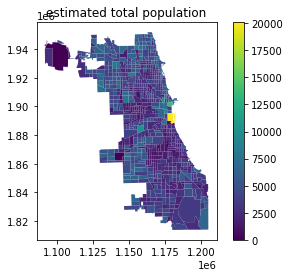

In [9]:
spatial_operations.simple_map(data, variable = 'estimated total population', target_geography = 'tract')

Like we just did, you can use `simple_map` with a plain pandas dataframe as long as it has a column with labels for the specified geography - it doesn't have to be a geodataframe because `simple_map` will look up and join the relevant shapefiles automatically.

But we might want to go ahead and convert our dataframe to a geodataframe for other purposes. We can use our `geographize` function to do this. This function takes two arguments: a dataframe and a geography of interest (again, labels for this geography must be one of the dataframe's columns).

We currently support the following geographical levels in Chicago:
- census blocks
- tracts
- community areas
- wards

In [10]:
# make data a geodataframe (which narrows it to Chicago tracts, because those are all we have in the shapefile)
data = spatial_operations.geographize(data, target_geography = 'tract')
type(data)

geopandas.geodataframe.GeoDataFrame

In [11]:
spatial_operations.simple_map(data, variable = 'estimated total population',target_geography = 'tract')

ValueError: You have multiple data points for the same geographical unit. Combine these data points and try again.

We have also written a function, `aggregate`, to convert between levels of geographical unit. As the name implies, this should generally be done going _upwards_ (or at least sideways) in level, like from tract to community area rather than community area to tract. Going downwards isn't generally a good idea because of the ecological fallacy (knowing something about the whole doesn't mean we know something about the parts).

`aggregate`'s arguments are slightly more complicated. It takes data to convert, a dictionary of variables to convert, a target geography, and a source geography.

To expand on the dictionary of variables: there are a couple of different ways to convert variables to a new areal unit. If the variables are intensive (that is, they _don't_ depend on the size of the area they're in), we can convert via area-weighted mean (`'areal mean'`) or population-weighted mean (`'pop mean'`). If the variables are extensive (they _do_ depend on the size of the area they're in), we can convert via area-weighted sum (`'areal sum'`). The variable dictionary should be of the form `{'variable name' : 'converstion method'}`.

`aggregate` always outputs a dataframe, even if a geodataframe was passed. You can convert the output to a geodataframe with `geographize`.

In [12]:
# this produces a dataframe of estimated total population calculated on the community area level from the tract level via area-weighted sum
community_area_data = spatial_operations.aggregate(data,{'estimated total population' : 'areal sum'},target_geography='community_area',source_geography='tract')
community_area_data.head()

ValueError: You have multiple data points for the same geographical unit. Combine these data points and try again.

Note: these community area estimates are very close to the "actual" populations per online sources. The most populous neighborhoods are Near North Side, Lakeview, and Austin, which are also the brightest colors in the map below.

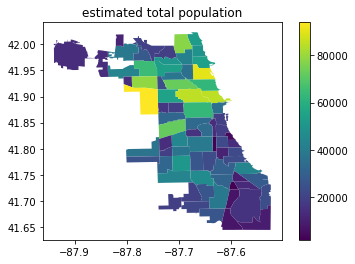

In [ ]:
spatial_operations.simple_map(community_area_data,'estimated total population','community_area')

Now let's try for an intensive variable (population density).

In [ ]:
# create population density variable
data['population density']=data['estimated total population']/data.area

In [ ]:
variables = {'estimated total population' : 'areal sum', 'population density' : 'areal mean'}
new_community_area_data = spatial_operations.aggregate(data,variables,target_geography='community_area',source_geography='tract')
new_community_area_data.head()

,community_area,estimated total population,population density
0,ALBANY PARK,49961.187298,9.247644e+07
1,ARCHER HEIGHTS,13813.340737,2.453914e+07
2,ARMOUR SQUARE,13615.114045,4.869143e+07
3,ASHBURN,43493.698832,3.194186e+07
4,AUBURN GRESHAM,45990.552782,4.353191e+07


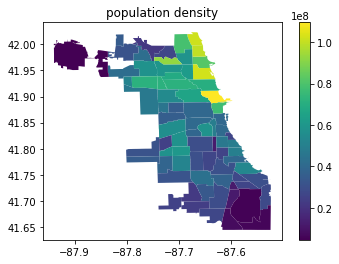

In [ ]:
spatial_operations.simple_map(new_community_area_data,'population density','community_area')

Let's compare that map we just produced to what we get if we calculate population density directly from population at the community level (rather than calculating at tract level and THEN aggregating like we just did).

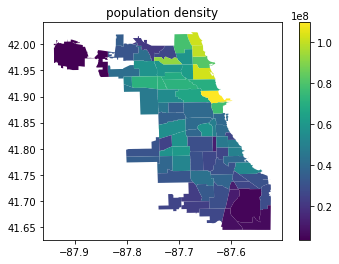

In [ ]:
community_area_data = spatial_operations.geographize(community_area_data,'community_area')
community_area_data['population density']=community_area_data['estimated total population']/community_area_data.area
spatial_operations.simple_map(community_area_data,'population density','community_area')

One final validation: let's create a new population column by multiplying each community area's calculated population density times area.

In [ ]:
# Watch out!!! This below line of code does NOT work properly to assign an area column to our dataframe. Why not?
# new_community_area_data['area'] = spatial_operations.geographize(new_community_area_data,'community_area').area
# (Answer: geographize does NOT necessarily return results in same order that we have dataframe in right now.)

new_community_area_data = new_community_area_data.sort_values(by="community_area")
# get areas IN SAME ORDER
areas = spatial_operations.geographize(new_community_area_data,'community_area').sort_values(by="community_area").reset_index().area
new_community_area_data['area'] = areas

In [ ]:
new_community_area_data['recalculated population'] = new_community_area_data['population density']*new_community_area_data['area']

In [ ]:
new_community_area_data.head()

,community_area,estimated total population,population density,area,recalculated population
0,ALBANY PARK,49961.187298,9.247644e+07,0.000540,49961.187298
1,ARCHER HEIGHTS,13813.340737,2.453914e+07,0.000563,13813.340737
2,ARMOUR SQUARE,13615.114045,4.869143e+07,0.000280,13615.114045
3,ASHBURN,43493.698832,3.194186e+07,0.001362,43509.988193
4,AUBURN GRESHAM,45990.552782,4.353191e+07,0.001056,45990.552782


In [ ]:
community_area_data['area']=community_area_data.area
community_area_data['density from area']=community_area_data['estimated total population']/community_area_data['area']
community_area_data['density from shape_area']=community_area_data['estimated total population']/community_area_data['shape_area']
community_area_data['recalculated pop']=community_area_data['population density']*community_area_data['area']

In [ ]:
community_area_data.head()

,area,area_num_1,area_numbe,comarea,comarea_id,community_area,perimeter,shape_area,shape_len,geometry,estimated total population,population density,density from area,density from shape_area,recalculated pop
0,0.000463,35,35,0.0,0.0,DOUGLAS,0.0,4.600462e+07,31027.054510,"POLYGON ((-87.60914 41.84469, -87.60915 41.844...",18756.276354,4.048936e+07,4.048936e+07,0.000408,18756.276354
1,0.000170,36,36,0.0,0.0,OAKLAND,0.0,1.691396e+07,19565.506153,"POLYGON ((-87.59215 41.81693, -87.59231 41.816...",4417.408055,2.594153e+07,2.594153e+07,0.000261,4417.408055
2,0.000200,37,37,0.0,0.0,FULLER PARK,0.0,1.991670e+07,25339.089750,"POLYGON ((-87.62880 41.80189, -87.62879 41.801...",2393.597361,1.193993e+07,1.193993e+07,0.000120,2393.597361
3,0.000488,38,38,0.0,0.0,GRAND BOULEVARD,0.0,4.849250e+07,28196.837157,"POLYGON ((-87.60671 41.81681, -87.60670 41.816...",22648.818032,4.639968e+07,4.639968e+07,0.000467,22648.818032
4,0.000293,39,39,0.0,0.0,KENWOOD,0.0,2.907174e+07,23325.167906,"POLYGON ((-87.59215 41.81693, -87.59215 41.816...",14178.445677,4.845414e+07,4.845414e+07,0.000488,14178.445677


All looks good!

We're working on developing a more useful interactive map that will allow you to have multiple layers and mouse over different geographic areas. We're thinking about how we could map multiple variables at once on it as well.

This is in early stages, but will be implemented in the `interactive_mapping` module (which requires installation of ipyleaflet, not just geopandas). The usage will be to instantiate InteractiveMap objects using a (geo)dataframe and target geography, then calling methods on the object to modify the map.

In [ ]:
from data_pipeline.interactive_mapping import InteractiveMap

In [ ]:
better_map = InteractiveMap(community_area_data,target_geography='community_area')

NameError: name 'community_area_data' is not defined

We can view the map by accessing the object's `map` attribute, as shown below. (Calling `map()` also returns the attribute.) The idea behind this implementation is that we can mostly use the simpler methods of our InteractiveMap class to create maps, but if needed can directly use more complex ipyleaflet methods on the `map` attribute. 

In [ ]:
better_map.map

Map(center=[41.85, -87.6], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

The default center and zoom of the map is set within the [Geography] section of `config.ini`. 

The key planned method we'll implement for InteractiveMap is `add_variable(<variable>)` to create additional layers of mapped variables. 